In [5]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import re
import pandas as pd
import plotting
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns


%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf
tf.random.set_seed(seed)

import sys
import os
# Add the directory containing callbacks.py to sys.path
sys.path.append(os.path.join(os.getcwd(), "hls4ml-tutorial_OPENML"))

# Simulate sourcing the script to set variables (as a fallback)
os.environ['XILINX_VITIS'] = '/opt/local/Vitis_HLS/2024.1'  # Adjust this path as needed
# Update the PATH variable
os.environ['PATH'] = os.path.join(os.environ['XILINX_VITIS'], 'bin') + ':' + os.environ.get('PATH', '')

In [6]:
# data = fetch_openml('hls4ml_lhc_jets_hlf', as_frame=False)
# X, y = data['data'], data['target']

# print(data['feature_names'])
# print(X.shape, y.shape)
# print(X[:5])
# print(y[:5])

In [7]:
# Some settings

fontsize = 15
weight = 0.1
plt.rcParams['font.size'] = fontsize
plt.rcParams["axes.titlesize"]  = fontsize + 5
# plt.rcParams["axes.titleweight"] = weight
plt.rcParams["axes.labelsize"] = fontsize
# plt.rcParams["axes.labelweight"] = weight
plt.rcParams["xtick.labelsize"] = fontsize
plt.rcParams["ytick.labelsize"] = fontsize

# Load the data

X_train_val = np.load('X_train_val.npy')
X_test = np.load('X_test.npy')
y_train_val = np.load('y_train_val.npy')
y_test = np.load('y_test.npy')
classes = np.load('classes.npy', allow_pickle=True)


In [8]:
def parse_utilization(report_text):
    """
    Parse the Utilization table to extract DSP, LUT, and BRAM usage.
    
    This function searches for a table row that starts with "|Utilization (%)"
    and then extracts the following columns (after splitting on "|"):
    
      - Column 2: BRAM_18K usage (we call this BRAM)
      - Column 3: DSP usage
      - Column 5: LUT usage
      
    Any occurrence of "~0" is replaced with 0.
    Returns dsp, lut, bram as floats.
    """
    dsp = lut = bram = None
    for line in report_text.splitlines():
        if line.strip().startswith("|Utilization (%)"): # or can use |Total for total amount instead
            # Split the line by "|" and remove empty strings/spaces.
            parts = [p.strip() for p in line.split("|") if p.strip()]
            if len(parts) < 6:
                continue
            # Expected order: 
            # parts[0] = "Utilization (%)"
            # parts[1] = BRAM_18K usage
            # parts[2] = DSP usage
            # parts[3] = FF usage (ignored)
            # parts[4] = LUT usage
            # parts[5] = URAM usage (ignored)
            try:
                bram = float(parts[1].replace("~0", "0"))
            except:
                bram = 0.0
            try:
                dsp = float(parts[2].replace("~0", "0"))
            except:
                dsp = 0.0
            try:
                lut = float(parts[4].replace("~0", "0"))
            except:
                lut = 0.0
            break
    return dsp, lut, bram

def parse_latency(report_text):
    """
    Parse the Performance Estimates section to extract the latency (in ns).
    
    The report typically contains a table like:
    
        +---------+---------+-----------+-----------+-----+-----+---------+
        |   Latency (cycles) |   Latency (absolute)  |  Interval | Pipeline|
        |   min   |   max   |    min    |    max    | min | max |   Type  |
        +---------+---------+-----------+-----------+-----+-----+---------+
        |       16|       16|  80.000 ns|  80.000 ns|    1|    1|      yes|
        +---------+---------+-----------+-----------+-----+-----+---------+
    
    This function searches for a header line containing both "Latency (cycles)" 
    and "Latency (absolute)" and then looks for a data row (the next row with "ns").
    It extracts the first occurrence of a latency value (in ns) and returns it as a float.
    """
    lines = report_text.splitlines()
    for i, line in enumerate(lines):
        if "Latency (cycles)" in line and "Latency (absolute)" in line:
            # Now scan subsequent lines
            for j in range(i+1, len(lines)):
                data_line = lines[j].strip()
                # Check that the line starts with "|" and has either "ns" or "us"
                if data_line.startswith("|") and ("ns" in data_line or "us" in data_line):
                    # Split the line by "|" and remove empty strings.
                    parts = [p.strip() for p in data_line.split("|") if p.strip()]
                    
                    # Skip header rows that have text (like "min") instead of numbers.
                    try:
                        # Try converting the first token to a float.
                        float(parts[0])
                    except ValueError:
                        continue  # Likely a header row; skip it.
                    
                    if len(parts) >= 4:
                        # The first "Latency (absolute)" value is in parts[2].
                        latency_token = parts[2]
                        # Check if the value is in microseconds and convert it to ns.
                        if "us" in latency_token:
                            try:
                                latency_val = float(latency_token.replace("us", "").strip()) * 1000
                            except Exception as e:
                                print("Error converting latency value in us:", latency_token, e)
                                return None
                        elif "ns" in latency_token:
                            try:
                                latency_val = float(latency_token.replace("ns", "").strip())
                            except Exception as e:
                                print("Error converting latency value in ns:", latency_token, e)
                                return None
                        else:
                            # No units found; assume the value is already a float.
                            try:
                                latency_val = float(latency_token.strip())
                            except Exception as e:
                                print("Error converting latency value:", latency_token, e)
                                return None
                        return latency_val
            break
    return None

def process_vivado_reports(report_paths, config_labels, accuracy_values):
    """
    Process multiple HLS/Vivado reports and return a pandas DataFrame.
    
    Parameters:
      - report_paths: list of paths to .rpt files.
      - config_labels: list of labels for each configuration (e.g., "Pruning 60%")
      - accuracy_values: list of accuracy values (in %) corresponding to each report
      
    The function extracts:
        • DSP, LUT, and BRAM utilization from the "Utilization (%)" table
        • Latency (in ns) from the Performance Estimates section
        
    The efficiency score is computed as:
    
         Efficiency Score = Accuracy / (DSP + LUT + BRAM + Latency)
    
    (Note: Make sure that your units and formula match your needs.)
    
    Returns a pandas DataFrame with columns:
      - Configuration
      - Accuracy (%)
      - DSP (%)
      - LUT (%)
      - BRAM (%)
      - Latency (ns)
      - Efficiency Score
    """
    if not (len(report_paths) == len(config_labels) == len(accuracy_values)):
        raise ValueError("Length of report_paths, config_labels, and accuracy_values must be the same.")
    
    results = []
    for path, label, accuracy in zip(report_paths, config_labels, accuracy_values):
        try:
            with open(path, "r") as f:
                content = f.read()
        except Exception as e:
            print(f"Error reading {path}: {e}")
            continue
        
        dsp, lut, bram = parse_utilization(content)
        latency = parse_latency(content)
        if dsp is None or lut is None or bram is None or latency is None:
            print(f"Skipping {path} due to parsing error.")
            continue
        
        denominator = dsp + lut + bram + latency
        efficiency = accuracy / denominator if denominator else 0.0
        
        results.append({
            "Configuration": label,
            "Accuracy (%)": accuracy,
            "DSP (%)": dsp,
            "LUT (%)": lut,
            "BRAM (%)": bram,
            "Latency (ns)": latency,
            "Efficiency Score": efficiency
        })
    
    df = pd.DataFrame(results)
    return df


def plot_confusion_matrix(y_pred, y_true, class_labels, title='Normalized Confusion Matrix'):
    """
    Plot a normalized confusion matrix.

    Args:
        y_pred (np.ndarray): Predicted probabilities or logits for each class (shape: [n_samples, n_classes]).
        y_true (np.ndarray): One-hot or multi-class targets (shape: [n_samples, n_classes]).
        class_labels (List[str]): List of class label names.
        title (str): Title for the plot.
    """
    # Convert probabilities to class indices
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_true, axis=1)

    # Compute confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)

    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

    # Create the heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm_normalized,
        annot=True,
        cmap="Blues",
        fmt=".2f",
        xticklabels=class_labels,
        yticklabels=class_labels
    )
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

### Base Model

In [9]:
model_ref = load_model('/home/hep/lr1424/hls4ml-tutorial_OPENML/model_1/KERAS_check_best_model.h5')
model_hls_ref = load_model('/home/hep/lr1424/hls4ml-tutorial_OPENML/model_1/KERAS_check_best_model.h5')
y_ref = model_ref.predict(X_test)


5188/5188 [==============================] - 11s 2ms/step


Accuracy: 0.7340240963855422


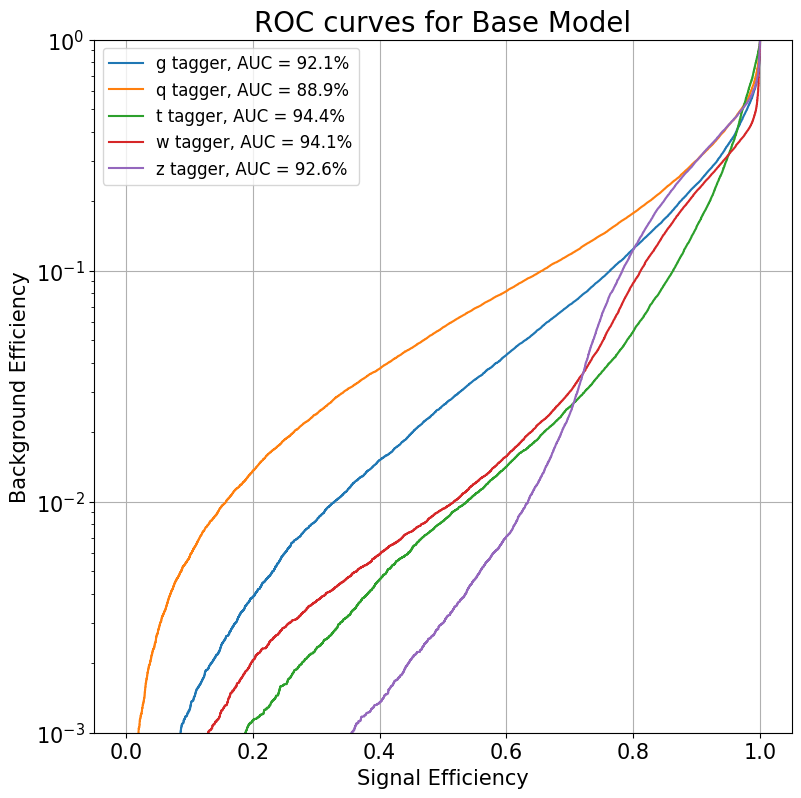

In [10]:
print("Accuracy:", accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_ref, axis=1)))

plt.figure(figsize=(9, 9))
plt.title('ROC curves for Base Model')
_ = plotting.makeRoc(y_test, y_ref, classes, text=False)

### Reuse Factor

### No ROC Curve or Confusion Matrix because the model is the same

     Configuration  Accuracy (%)  DSP (%)  LUT (%)  BRAM (%)  Latency (ns)  \
0   Reuse Factor 1         73.40     24.0      7.0       0.0          75.0   
1   Reuse Factor 2         73.39     17.0      8.0       0.0          95.0   
2   Reuse Factor 6         73.37      5.0      8.0       0.0         155.0   
3  Reuse Factor 10         73.39      3.0      8.0       0.0         210.0   

   Efficiency Score  
0          0.692453  
1          0.611583  
2          0.436726  
3          0.332081  


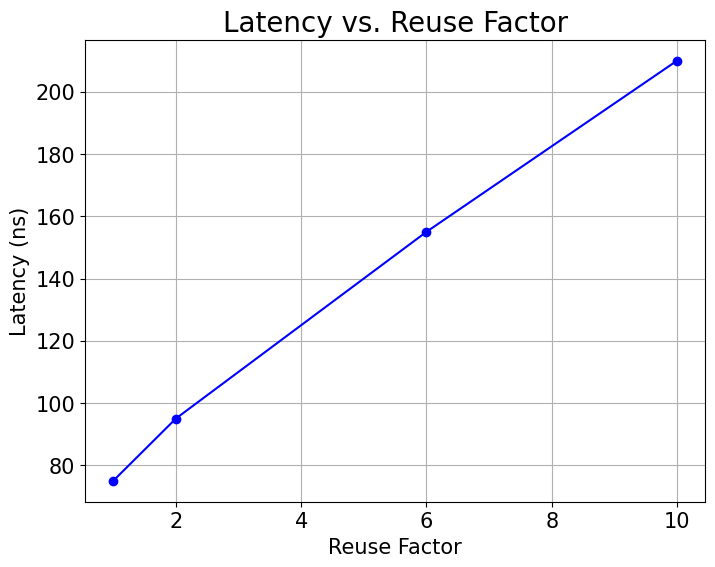

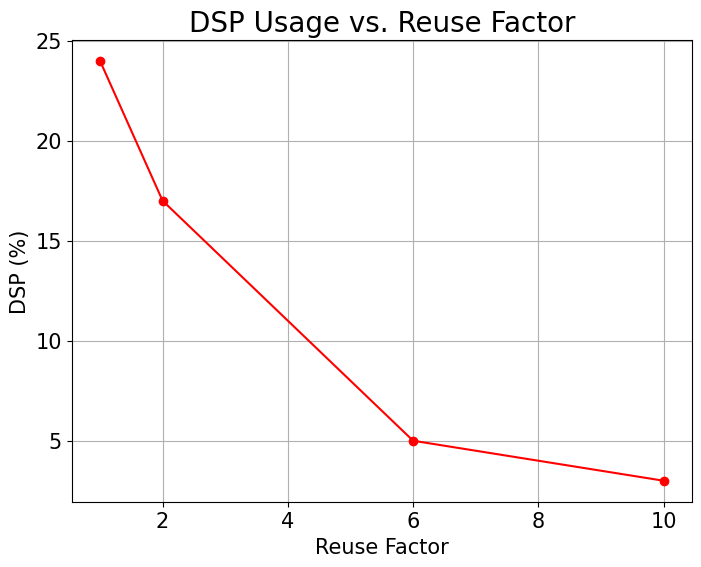

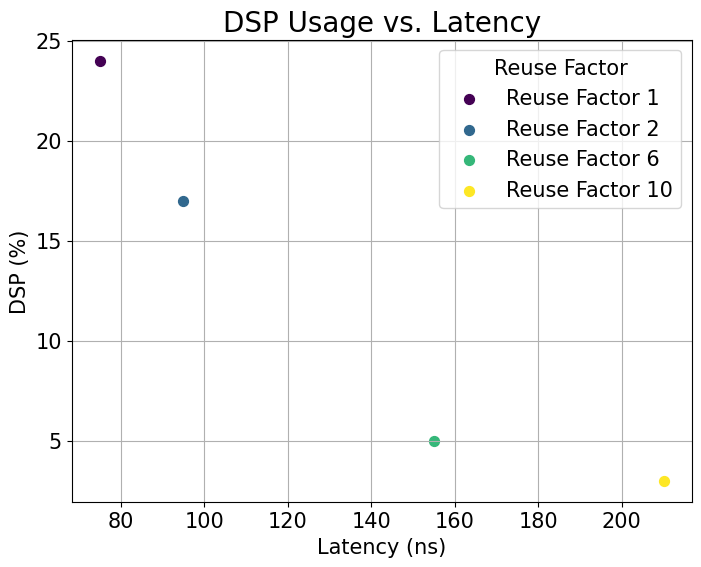

In [11]:
report_paths_reuse = [
    "/home/hep/lr1424/hls4ml-tutorial_OPENML/model_1/hls4ml_prj/myproject_prj/solution1/syn/report/myproject_csynth.rpt",
    "/home/hep/lr1424/hls4ml-tutorial_OPENML/model_1/hls4ml_prj_3/myproject_prj/solution1/syn/report/myproject_csynth.rpt",
    "/home/hep/lr1424/hls4ml-tutorial_OPENML/model_1/hls4ml_prj_4/myproject_prj/solution1/syn/report/myproject_csynth.rpt",
    "/home/hep/lr1424/hls4ml-tutorial_OPENML/model_1/hls4ml_prj_5/myproject_prj/solution1/syn/report/myproject_csynth.rpt"
]

config_labels_reuse = ["Reuse Factor 1", "Reuse Factor 2", "Reuse Factor 6", "Reuse Factor 10"]

# hls4ml_rf1 Accuracy: 0.7342530120481928
# hls4ml_rf2 Accuracy: 0.7339397590361446
# hls4ml_rf6 Accuracy: 0.7339397590361446
# hls4ml_rf10 Accuracy: 0.7339397590361446

accuracy_values_reuse = [
    73.40,
    73.39,
    73.37,
    73.39
]

#  accuracy_values_reuse = [a * 100 for a in accuracy_values_reuse]  # Convert to percentage

df_reuse = process_vivado_reports(report_paths_reuse, config_labels_reuse, accuracy_values_reuse)

print(df_reuse)

df_reuse['reuse_factor'] = df_reuse['Configuration'].str.extract(r'Reuse Factor (\d+)', expand=False).astype(float)
df_reuse = df_reuse.sort_values('reuse_factor')

plt.figure(figsize=(8,6))
plt.plot(df_reuse['reuse_factor'], df_reuse['Latency (ns)'],
         marker='o', linestyle='-', color='blue')
plt.xlabel('Reuse Factor')
plt.ylabel('Latency (ns)')
plt.title('Latency vs. Reuse Factor')
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(df_reuse['reuse_factor'], df_reuse['DSP (%)'],
         marker='o', linestyle='-', color='Red')
plt.xlabel('Reuse Factor')
plt.ylabel('DSP (%)')
plt.title('DSP Usage vs. Reuse Factor')
plt.grid(True)
plt.show()

unique_configs = df_reuse['Configuration'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_configs)))

# plt.figure(figsize=(8, 6))

# # Loop over each configuration group and plot the corresponding points.
# for config, color in zip(unique_configs, colors):
#     group = df_reuse[df_reuse['Configuration'] == config]
#     plt.scatter(group['DSP (%)'], group['Accuracy (%)'],
#                 s=50, label=config, color=color)

# plt.xlabel('DSP (%)')
# plt.ylabel('Accuracy (%)')
# plt.title('Accuracy vs. DSP Usage')
# plt.ylim(50,100)
# plt.xlim(0,40)
# plt.grid(True)
# plt.legend(title='Reuse Factor', loc = "lower right")
# plt.show()

plt.figure(figsize=(8, 6))

# Loop over each configuration group and plot the corresponding points.
for config, color in zip(unique_configs, colors):
    group = df_reuse[df_reuse['Configuration'] == config]
    plt.scatter(group['Latency (ns)'], group['DSP (%)'],
                s=50, label=config, color=color)

plt.xlabel('Latency (ns)')
plt.ylabel('DSP (%)')
plt.title('DSP Usage vs. Latency')
# plt.ylim(50,100)
# plt.xlim(0,30)
plt.grid(True)
plt.legend(title='Reuse Factor', loc = "upper right")
plt.show()

### Pruning

Accuracy 75%:   0.748020634920635

Accuracy 60%:   0.716479365079365

Accuracy 90%:   0.7447920634920635

  Configuration  Accuracy (%)  DSP (%)  LUT (%)  BRAM (%)  Latency (ns)  \
0    Pruning 0%         73.44     24.0      7.0       0.0          75.0   
1   Pruning 60%         75.98     13.0      4.0       0.0          70.0   
2   Pruning 75%         75.56     20.0     11.0       0.0          70.0   
3   Pruning 90%         76.13     13.0      4.0       0.0          70.0   

   Efficiency Score  
0          0.692830  
1          0.873333  
2          0.748119  
3          0.875057  


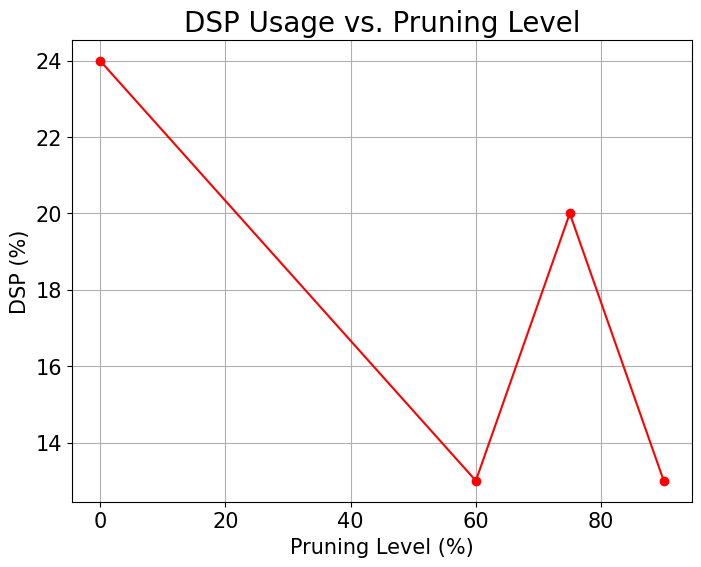

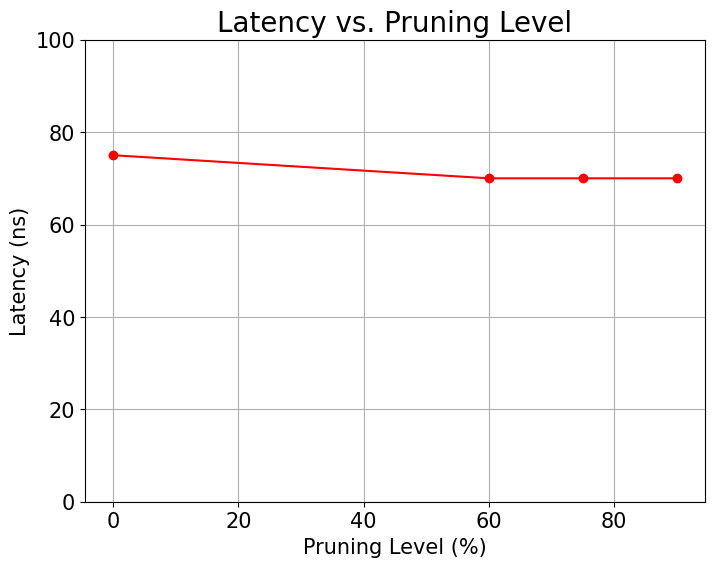

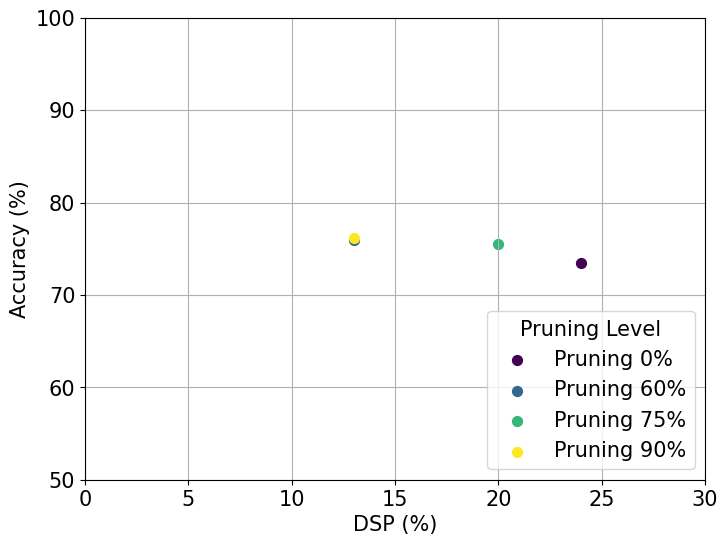

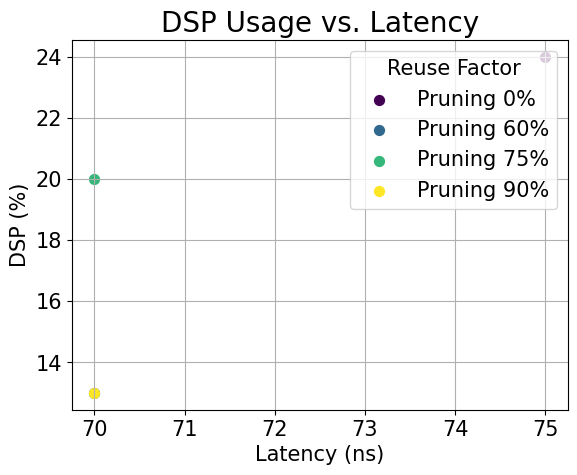

In [12]:
report_paths_prune = [
    "/home/hep/lr1424/hls4ml-tutorial_OPENML/model_1/hls4ml_prj/myproject_prj/solution1/syn/report/myproject_csynth.rpt",
    "/home/hep/lr1424/hls4ml-tutorial_OPENML/model_2.1/hls4ml_prj_prune_60/myproject_prj/solution1/syn/report/myproject_csynth.rpt",
    "/home/hep/lr1424/hls4ml-tutorial_OPENML/model_2/hls4ml_prj_prune_75/myproject_prj/solution1/syn/report/myproject_csynth.rpt",  
    "/home/hep/lr1424/hls4ml-tutorial_OPENML/model_2.2/hls4ml_prj_prune_90/myproject_prj/solution1/syn/report/myproject_csynth.rpt"
]
config_labels_prune = ["Pruning 0%", "Pruning 60%", "Pruning 75%", "Pruning 90%"]  

# Accuracy 60%:   0.7598493975903614
# Accuracy 75%:   0.7556325301204819
# Accuracy 90%:   0.7612530120481927
# Accuracy 0%:    0.7344156626506024

accuracy_values_prune = [73.44, 75.98, 75.56, 76.13]  

df_prune = process_vivado_reports(report_paths_prune, config_labels_prune, accuracy_values_prune)
print(df_prune)

df_prune['pruning'] = df_prune['Configuration'].str.extract(r'Pruning (\d+)%', expand=False).astype(float)
df_prune['Total Resources'] = df_prune['DSP (%)'] + df_prune['LUT (%)'] + df_prune['BRAM (%)']

plt.figure(figsize=(8,6))
plt.plot(df_prune['pruning'], df_prune['DSP (%)'],
         marker='o', linestyle='-', color='red')
plt.xlabel('Pruning Level (%)')
plt.ylabel('DSP (%)')
plt.title('DSP Usage vs. Pruning Level')
# plt.ylim(min(df_prune['DSP (%)']) - 3, max(df_prune['DSP (%)']))
# plt.xlim(0,30)
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(df_prune['pruning'], df_prune['Latency (ns)'],
         marker='o', linestyle='-', color='red')
plt.xlabel('Pruning Level (%)')
plt.ylabel('Latency (ns)')
plt.title('Latency vs. Pruning Level')
plt.ylim(0, 100)
# plt.xlim(0,30)
plt.grid(True)
plt.show()

unique_configs = df_prune['Configuration'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_configs)))

plt.figure(figsize=(8, 6))

# Loop over each configuration group and plot the corresponding points.
for config, color in zip(unique_configs, colors):
    group = df_prune[df_prune['Configuration'] == config]
    plt.scatter(group['DSP (%)'], group['Accuracy (%)'],
                s=50, label=config, color=color)

plt.xlabel('DSP (%)')
plt.ylabel('Accuracy (%)')
# plt.title('Accuracy vs. Resource Usage (Annotated by Pruning Level)')
plt.ylim(50,100)
plt.xlim(0,30)
plt.grid(True)
plt.legend(title='Pruning Level', loc = "lower right")
plt.show()

# Loop over each configuration group and plot the corresponding points.
for config, color in zip(unique_configs, colors):
    group = df_prune[df_prune['Configuration'] == config]
    plt.scatter(group['Latency (ns)'], group['DSP (%)'],
                s=50, label=config, color=color)

plt.xlabel('Latency (ns)')
plt.ylabel('DSP (%)')
plt.title('DSP Usage vs. Latency')
# plt.ylim(50,100)
# plt.xlim(0,30)
plt.grid(True)
plt.legend(title='Reuse Factor', loc = "upper right")
plt.show()

### ROC Curves - NB: Predicting Takes 30s

In [13]:
model = load_model('/home/hep/lr1424/hls4ml-tutorial_OPENML/model_2.1/KERAS_check_best_model.h5')
model2 = load_model('/home/hep/lr1424/hls4ml-tutorial_OPENML/model_2/KERAS_check_best_model.h5')
model3 = load_model('/home/hep/lr1424/hls4ml-tutorial_OPENML/model_2.2/KERAS_check_best_model.h5')


y_prune = model.predict(X_test)
y_prune2 = model2.predict(X_test)
y_prune3 = model3.predict(X_test)

5188/5188 [==============================] - 12s 2ms/step


Accuracy unpruned: 0.7340240963855422
Accuracy 75%:   0.7546144578313253
Accuracy 60%:   0.7607469879518072
Accuracy 90%:   0.7597108433734939


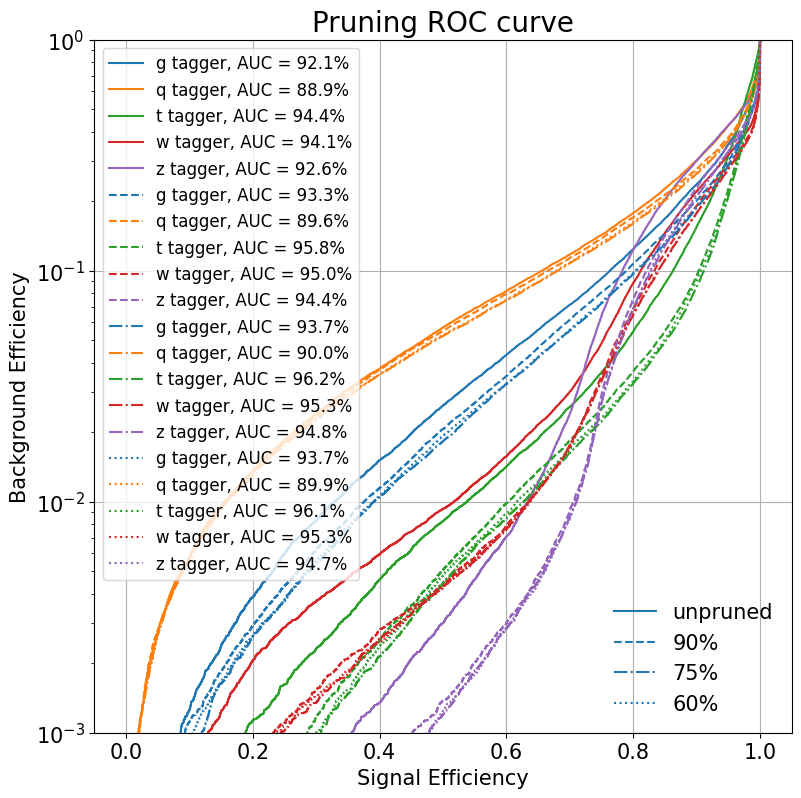

In [14]:
import plotting
print("Accuracy unpruned: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_ref, axis=1))))
print("Accuracy 75%:   {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_prune, axis=1))))
print("Accuracy 60%:   {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_prune2, axis=1))))
print("Accuracy 90%:   {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_prune3, axis=1))))

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_ref, classes, text=False)
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test, y_prune, classes, linestyle='--', text=False)
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test, y_prune2, classes, linestyle='-.', text=False)
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test, y_prune3, classes, linestyle=':', text=False)
plt.title('Pruning ROC curve')

from matplotlib.lines import Line2D

lines = [Line2D([0], [0], ls='-'), Line2D([0], [0], ls='--'), Line2D([0], [0], ls='-.'), Line2D([0], [0], ls=':')]
from matplotlib.legend import Legend

leg = Legend(ax, lines, labels=['unpruned', '90%', '75%', '60%'], loc='lower right', frameon=False)
ax.add_artist(leg)

### Confusion Matrix

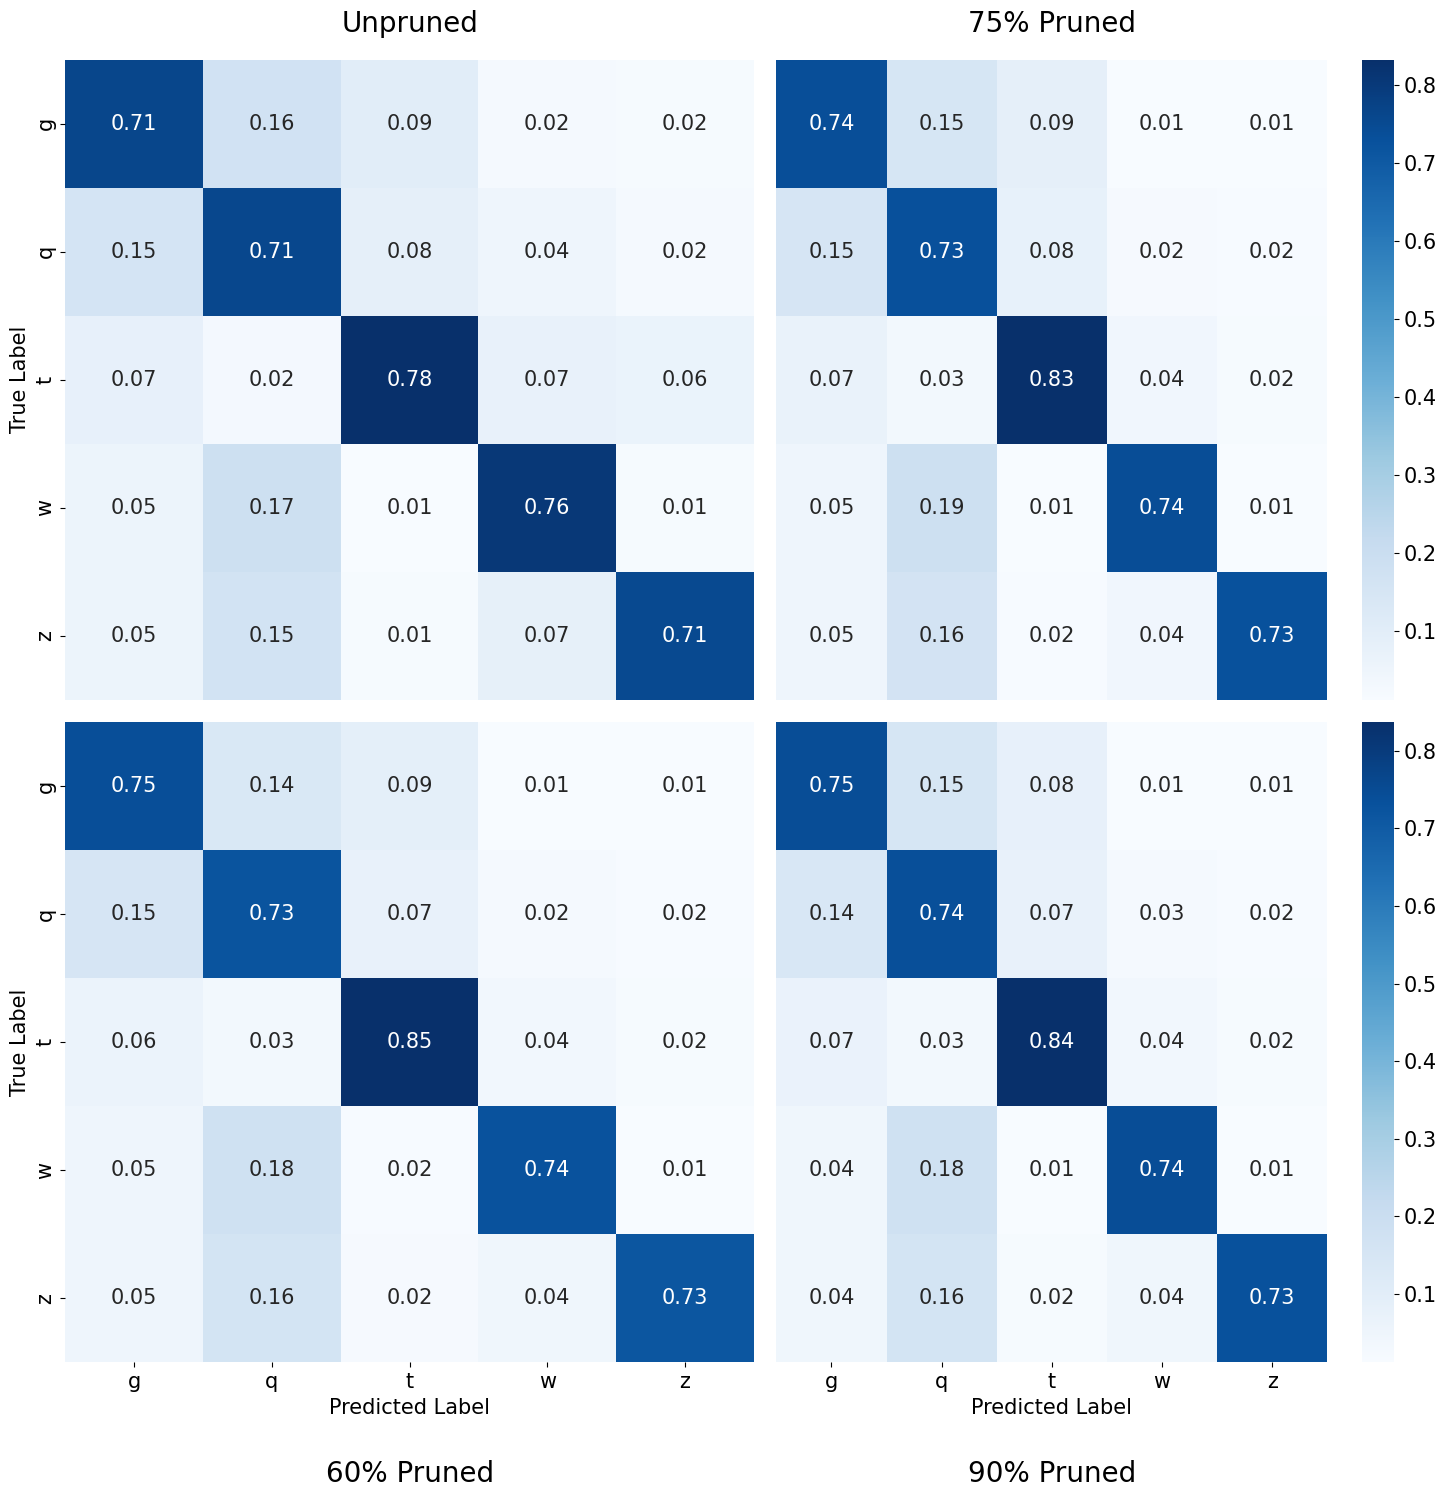

In [15]:
plt.figure(figsize=(15, 15))

# Plot confusion matrix for unpruned model
plt.subplot(2, 2, 1)
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_ref, axis=1))
cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)
sns.heatmap(cm_normalized, annot=True, cmap="Blues", fmt=".2f", 
            xticklabels=[], yticklabels=classes, cbar=False)
plt.title('Unpruned', pad=20)
plt.ylabel("True Label")

# Plot confusion matrix for 75% pruned model
plt.subplot(2, 2, 2)
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_prune, axis=1))
cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)
sns.heatmap(cm_normalized, annot=True, cmap="Blues", fmt=".2f",
            xticklabels=[], yticklabels=[])
plt.title('75% Pruned', pad=20)

# Plot confusion matrix for 60% pruned model
plt.subplot(2, 2, 3)
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_prune2, axis=1))
cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)
sns.heatmap(cm_normalized, annot=True, cmap="Blues", fmt=".2f",
            xticklabels=classes, yticklabels=classes, cbar=False)
plt.title('60% Pruned', y=-0.2)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Plot confusion matrix for 90% pruned model
plt.subplot(2, 2, 4)
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_prune3, axis=1))
cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)
sns.heatmap(cm_normalized, annot=True, cmap="Blues", fmt=".2f",
            xticklabels=classes, yticklabels=[])
plt.title('90% Pruned', y=-0.2)
plt.xlabel("Predicted Label")

plt.tight_layout()
plt.show()


### HGQ

  Configuration  Accuracy (%)  DSP (%)  LUT (%)  BRAM (%)  Latency (ns)  \
0      baseline         73.44     24.0      7.0       0.0          75.0   
1    beta=1e-07         76.80      1.0     10.0       0.0          50.0   
2    beta=6e-07         76.59      0.0      6.0       0.0          45.0   
3    beta=3e-06         75.84      0.0      1.0       0.0          40.0   
4    beta=2e-05         74.67      0.0      0.0       0.0          30.0   
5    beta=1e-04         70.97      0.0      0.0       0.0          20.0   

   Efficiency Score  
0          0.692830  
1          1.259016  
2          1.501765  
3          1.849756  
4          2.489000  
5          3.548500  


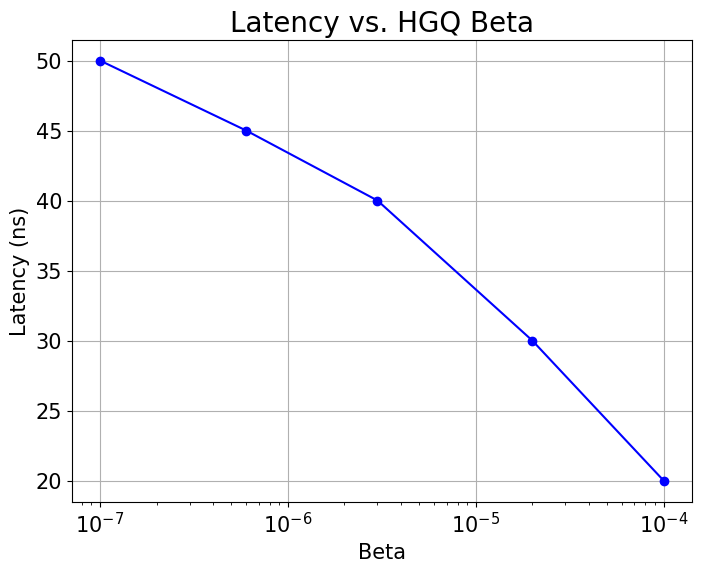

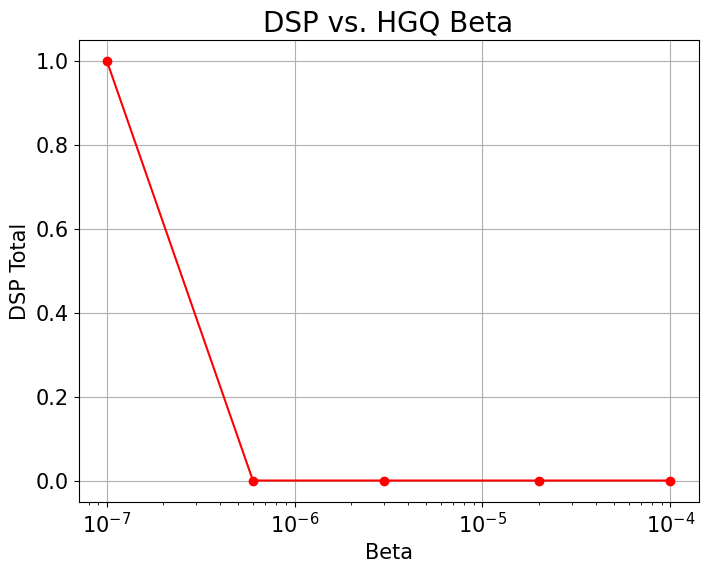

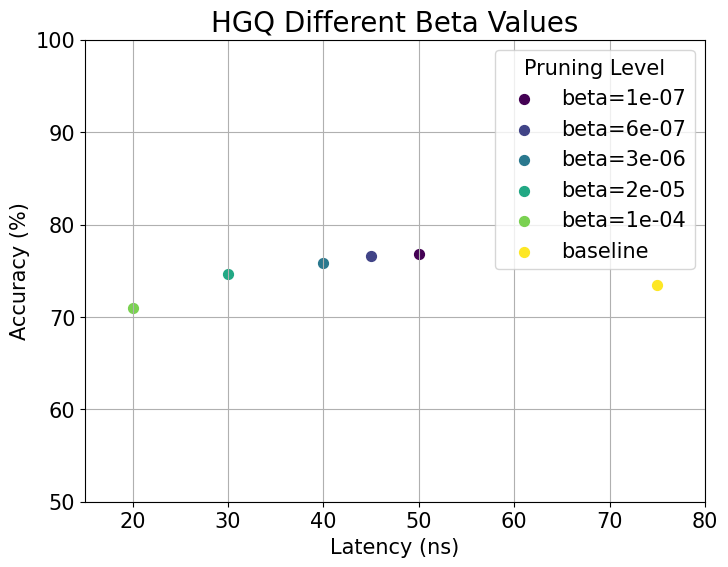

In [16]:
report_paths_hgq = [
    "/home/hep/lr1424/hls4ml-tutorial_OPENML/model_1/hls4ml_prj/myproject_prj/solution1/syn/report/myproject_csynth.rpt",
    "/home/hep/lr1424/hls4ml-tutorial_OPENML/model_3.1_1/hls4ml_prj/myproject_prj/solution1/syn/report/myproject_csynth.rpt",
    "/home/hep/lr1424/hls4ml-tutorial_OPENML/model_3.1_2/hls4ml_prj/myproject_prj/solution1/syn/report/myproject_csynth.rpt",
    "/home/hep/lr1424/hls4ml-tutorial_OPENML/model_3.1_3/hls4ml_prj/myproject_prj/solution1/syn/report/myproject_csynth.rpt",
    "/home/hep/lr1424/hls4ml-tutorial_OPENML/model_3.1_4/hls4ml_prj/myproject_prj/solution1/syn/report/myproject_csynth.rpt",
    "/home/hep/lr1424/hls4ml-tutorial_OPENML/model_3.1_5/hls4ml_prj/myproject_prj/solution1/syn/report/myproject_csynth.rpt"
]

# These labels should match the beta values used during HGQ model creation.
config_labels_hgq = ["baseline", "beta=1e-07", "beta=6e-07", "beta=3e-06", "beta=2e-05", "beta=1e-04"]

# Accuracy baseline:  0.7344156626506024
# Accuracy keras beta=1e-07: 0.7679879518072289
# Accuracy hls beta=1e-07: 0.7679879518072289
# Accuracy keras beta=6e-07: 0.7658915662650603
# Accuracy hls beta=6e-07: 0.7658915662650603
# Accuracy keras beta=3e-06: 0.7584397590361446
# Accuracy hls beta=3e-06: 0.7584397590361446
# Accuracy keras beta=2e-05: 0.7466927710843374
# Accuracy hls beta=2e-05: 0.7466927710843374
# Accuracy keras beta=1e-04: 0.7097289156626506
# Accuracy hls beta=1e-04: 0.7097289156626506

# Using hls accuracies
accuracy_values_hgq = [
    73.44,
    76.80,
    76.59,
    75.84,
    74.67,
    70.97
]
# accuracy_values_hgq = [a * 100 for a in accuracy_values_hgq]  # Convert to percentage

df_hgq = process_vivado_reports(report_paths_hgq, config_labels_hgq, accuracy_values_hgq)
print(df_hgq)

# Extract the beta value from the 'Configuration' column.
# This regex matches strings like "beta=1e-07" and converts the captured value to float.
df_hgq['beta'] = df_hgq['Configuration'].str.extract(r'beta=([\deE\.\-]+)', expand=False).astype(float)
df_hgq = df_hgq.sort_values('beta')

df_hgq['Total Resources'] = df_hgq['DSP (%)'] + df_hgq['LUT (%)'] + df_hgq['BRAM (%)']


# Plot latency vs. beta.
plt.figure(figsize=(8,6))
plt.plot(df_hgq['beta'], df_hgq['Latency (ns)'],
         marker='o', linestyle='-', color='blue')
plt.xscale('log')
plt.xlabel('Beta')
plt.ylabel('Latency (ns)')
plt.title('Latency vs. HGQ Beta')
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(df_hgq['beta'], df_hgq['DSP (%)'],
         marker='o', linestyle='-', color='Red')
plt.xscale('log')
plt.xlabel('Beta')
plt.ylabel('DSP Total')
plt.title('DSP vs. HGQ Beta')
plt.grid(True)
plt.show()

df_hgq.loc[0, 'Configuration'] = 'baseline'
unique_configs = df_hgq['Configuration'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_configs)))

plt.figure(figsize=(8, 6))

# Loop over each configuration group and plot the corresponding points.
for config, color in zip(unique_configs, colors):
    group = df_hgq[df_hgq['Configuration'] == config]
    plt.scatter(group['Latency (ns)'], group['Accuracy (%)'],
                s=50, label=config, color=color)

plt.xlabel('Latency (ns)')
plt.ylabel('Accuracy (%)')
plt.title('HGQ Different Beta Values')
plt.ylim(50,100)
plt.xlim(np.min(df_hgq['Latency (ns)'])-5, np.max(df_hgq['Latency (ns)'])+5)
plt.grid(True)
plt.legend(title='Pruning Level', loc = "upper right")
plt.show()

### ROC Curves - NB: Predicting Takes 1.5 mins (This stopped working when I switched chips? Not sure why)

In [17]:
models = {}
beta_values = np.logspace(-7, -4, num=5)  # 5 values from 1e-7 to 1e-4
models["model_1"] = load_model('/home/hep/lr1424/hls4ml-tutorial_OPENML/model_3.1_1/model.h5')
models["model_2"] = load_model('/home/hep/lr1424/hls4ml-tutorial_OPENML/model_3.1_2/model.h5')
models["model_3"] = load_model('/home/hep/lr1424/hls4ml-tutorial_OPENML/model_3.1_3/model.h5')
models["model_4"] = load_model('/home/hep/lr1424/hls4ml-tutorial_OPENML/model_3.1_4/model.h5')
models["model_5"] = load_model('/home/hep/lr1424/hls4ml-tutorial_OPENML/model_3.1_5/model.h5')

hls_models = {}
y_keras_dict = {}
y_hls_dict = {}
y_softmax_dict = {}
for name, model in models.items():
    X_test = np.ascontiguousarray(X_test)
    # y_keras = model.predict(X_test, batch_size=16384, verbose=0)

    y_hls = model.predict(X_test)
    # y_keras_dict[name] = y_keras
    y_hls_dict[name] = y_hls
            
    # Compute softmax outputs
    # y_keras_softmax = tf.nn.softmax(y_keras).numpy()
    y_hls_softmax = tf.nn.softmax(y_hls).numpy()
    print(f"Softmax computed for {name}")
    y_softmax_dict[name] = y_hls_softmax
    print("----------------------------------------------------------------------------")


ValueError: Unknown layer: 'HGQ>HQuantize'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

Accuracy baseline:  0.7340240963855422


NameError: name 'y_softmax_dict' is not defined

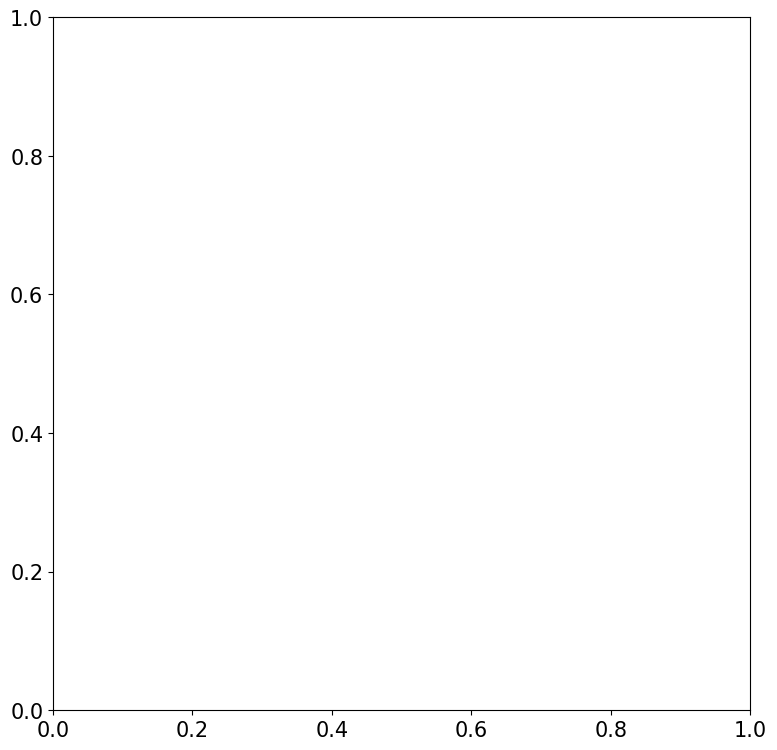

In [ ]:
print("Accuracy baseline:  {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_ref, axis=1))))

for i, (name, model) in enumerate(models.items(), start = 1):
    # Get the corresponding beta value (assuming the same order)
    beta_val = beta_values[i-1]
    # y_keras = y_keras_dict[name]
    y_hls = y_hls_dict[name]
    acc_keras = accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))
    acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))
    # print("Accuracy keras beta={:.0e}: {}".format(beta_val, acc_keras))
    print("Accuracy hls beta={:.0e}: {}".format(beta_val, acc))
    
fig, ax = plt.subplots(figsize=(9, 9))


linestyles = ['-', '--', '-.', ':']
# If there are more models than these 4, extend with the default solid linestyle.
if len(models) > len(linestyles):
    linestyles.extend([':'] * (len(models) - len(linestyles)))

# Plot each model's ROC curve with its corresponding linestyle.
for i, (name, y_softmax) in enumerate(y_softmax_dict.items()):
    _ = plotting.makeRoc(y_test, y_softmax, classes, linestyle=linestyles[i], text=False)
    plt.gca().set_prop_cycle(None)  # Reset the colors for the next call

# Create legend items matching the linestyles and beta values.
legend_lines = [Line2D([0], [0], ls=linestyles[i], lw=2) for i in range(len(models))]
legend_labels = [f'beta={beta_values[i]:.0e}' for i in range(len(models))]

# Add the legend to the plot
leg = Legend(ax, legend_lines, labels=legend_labels, loc='lower right', frameon=False)
ax.add_artist(leg)

plt.show()

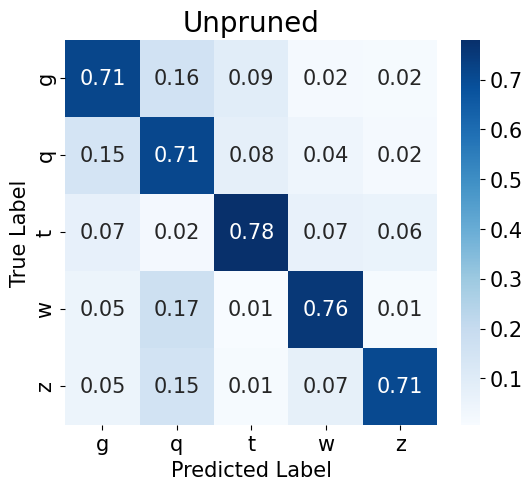

NameError: name 'y_rf1' is not defined

In [ ]:
plot_confusion_matrix(y_ref,    y_test, classes, title='Unpruned')
plot_confusion_matrix(y_rf1, y_test, classes, title='75% Pruned')
plot_confusion_matrix(y_rf2, y_test, classes, title='60% Pruned')
plot_confusion_matrix(y_rf10, y_test, classes, title='90% Pruned')